In [4]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [5]:
data_path = '/kaggle/input/dermnet/train'

# Loading the data

In [6]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

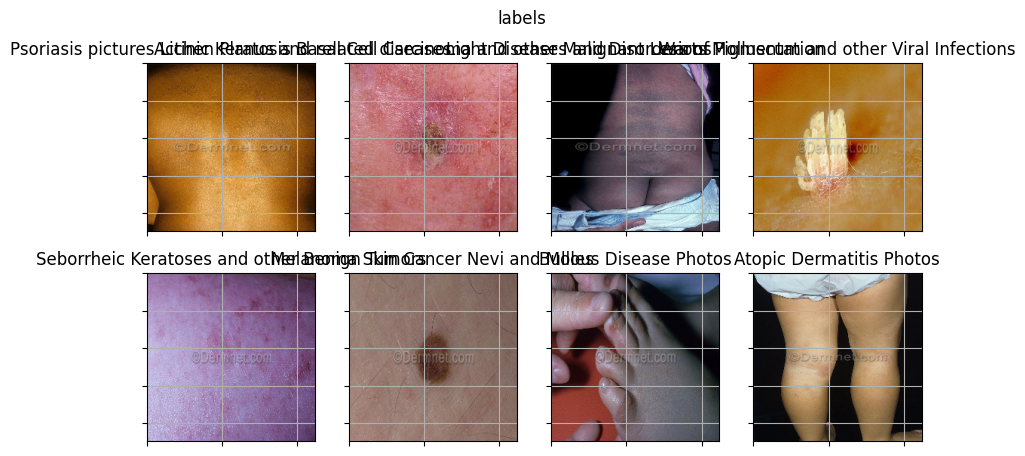

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('labels')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

# Preparing the model

In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [10]:
base_model.trainable = False

In [11]:
num_classes = 23
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# PREPROCESS DATA

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

# Training

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)


In [15]:
EPOCHS = 20
BATCH_SIZE = 64
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE,callbacks=[custom_early_stopping])

model.save('/kaggle/working/my_model.h5')

Epoch 1/20
195/195 [==============================] - 39s 169ms/step - loss: 2.4630 - accuracy: 0.2918 - val_loss: 2.2277 - val_accuracy: 0.3402
Epoch 2/20
195/195 [==============================] - 26s 131ms/step - loss: 2.0001 - accuracy: 0.4053 - val_loss: 2.1111 - val_accuracy: 0.3796
Epoch 3/20
195/195 [==============================] - 26s 131ms/step - loss: 1.7602 - accuracy: 0.4674 - val_loss: 2.0256 - val_accuracy: 0.4017
Epoch 4/20
195/195 [==============================] - 26s 131ms/step - loss: 1.5491 - accuracy: 0.5315 - val_loss: 1.9985 - val_accuracy: 0.4239
Epoch 5/20
195/195 [==============================] - 26s 131ms/step - loss: 1.3432 - accuracy: 0.5905 - val_loss: 2.0025 - val_accuracy: 0.4290
Epoch 6/20
195/195 [==============================] - 26s 131ms/step - loss: 1.1702 - accuracy: 0.6360 - val_loss: 2.0182 - val_accuracy: 0.4428
Epoch 7/20
195/195 [==============================] - 26s 132ms/step - loss: 1.0084 - accuracy: 0.6913 - val_loss: 2.0145 - val_ac

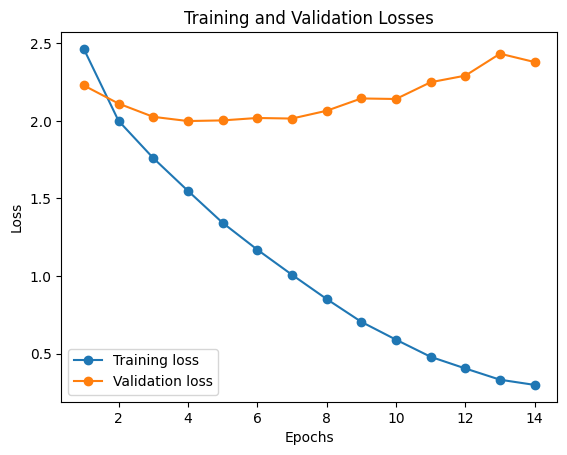

In [16]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

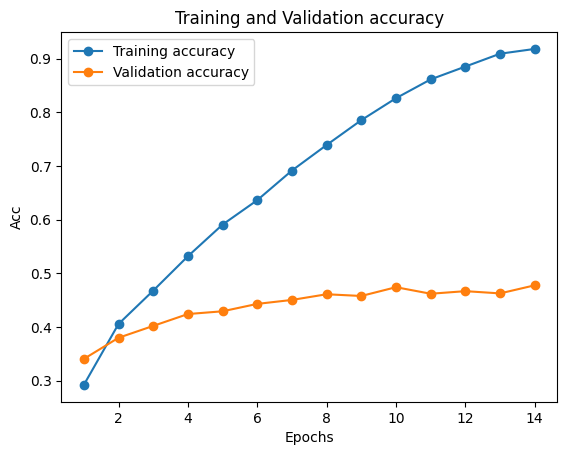

In [18]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()

# Prediction

In [2]:
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
test_path = '/kaggle/input/dermnet/test'

In [4]:
model = load_model('/kaggle/working/my_model.h5') 

OSError: No file or directory found at /kaggle/working/my_model.h5

In [22]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


1/1 [==============================] - 0s 22ms/step


In [23]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)

In [1]:
print(real_label)

NameError: name 'real_label' is not defined

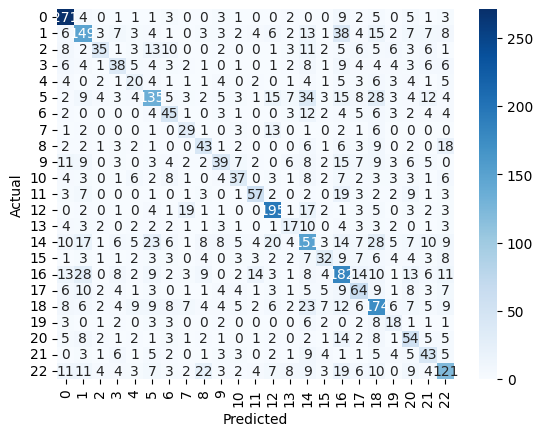

In [24]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
print(real_label[0], predicted_class[0])

Light Diseases and Disorders of Pigmentation Light Diseases and Disorders of Pigmentation
